# Continuous Entropy

https://gtas.unican.es/files/docencia/TICC/apuntes/tema1bwp_0.pdf \\
https://statproofbook.github.io/P/mvn-dent.html
- Gaussion distribution: 
$f(x)=\dfrac{1}{\sqrt{2\pi}\ ⋅ \sigma} e^{-\dfrac{1}{2 \sigma^2}(x-\mu)^2}$ 

- Joint Gaussion distribution:
$f_{X, Y}(x, y)=\dfrac{1}{2 \pi \sigma_X \sigma_Y \sqrt{1-\rho^2}} \exp \left[-\dfrac{1}{2\left(1-\rho^2\right)} S\right] \\S=\left(\dfrac{x-\mu_X}{\sigma_X}\right)^2+\left(\dfrac{y-\mu_Y}{\sigma_Y}\right)^2-2 \rho \dfrac{\left(x-\mu_X\right)\left(y-\mu_Y\right)}{\sigma_X \sigma_Y}\\ \rho=\rho(X, Y)=\dfrac{\operatorname{Cov}(X, Y)}{\sigma_X \sigma_Y} = \dfrac{\sum\limits_{i=1}^n\left(x_i-\mu_x\right)\left(y_i-\mu_y\right)}{\sqrt{\sum\limits_{i=1}^n\left(x_i-\mu_x\right)^2 \sum\limits_{i=1}^n\left(y_i-\mu_y\right)^2}}$

- Continuous Entropy:
$H(X)=\int_S f(x) \log \dfrac{1}{f(x)} d x ⇒ \dfrac{1}{2} \log \left(2 \pi e \sigma^2\right)$
- KL divergence(Relative Entropy):
$KL(P \| Q)=\int_S p(x) \log {\left(\dfrac{p(x)}{q(x)}\right)} d x ⇒ \dfrac{1}{2} \log e\left(\ln \left(\dfrac{\sigma_2^2}{\sigma_1^2}\right)+\dfrac{\sigma_1^2}{\sigma_2^2}+\dfrac{\left(\mu_1-\mu_2\right)^2}{\sigma_2^2}-1\right) ⇒ \dfrac{1}{2} \left(\ln \left(\dfrac{\sigma_2^2}{\sigma_1^2}\right)+\dfrac{\sigma_1^2}{\sigma_2^2}+\dfrac{\left(\mu_1-\mu_2\right)^2}{\sigma_2^2}-1\right)$
- Continuous JS-Entropy:
$JS(f(x)||g(x))={1 \over 2}(KL(f(x)||g(x))+KL(g(x)||f(x)))$
- Continuous Joint Entropy for Multivariate Gaussion
$H(X, Y)=-\int_{S_x} \int_{S_y} p(x, y) \log p(x, y) d x d y =\dfrac{n}{2} \ln (2 \pi)+\dfrac{1}{2} \ln |\Sigma|+\dfrac{1}{2} n $
- Continuous MI with matrix: $I(X ; Y)=\int_{S_x} \int_{S_y} p(x, y) \log \dfrac{p(x, y)}{p(x) p(y)} d x d y$ $= H(x)+H(y)-H(x,y) $

In [25]:
import pandas as pd
import numpy as np
import scipy.integrate as integrate
from scipy.integrate import dblquad
from dataclasses import dataclass
from scipy.linalg import det
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.metrics import r2_score
import scipy.stats as stats

@dataclass
class continuous:
    dependent_var: str = None

    def _gaussion(self, x, data_list):
        mean = np.mean(data_list)
        std = np.std(data_list) 
        return 1/(np.sqrt(2*np.pi)*std)*np.exp(-1/2*((x-mean)/std)**2)

    def _pearson_corr_coefficient(self, data_list_1, data_list_2):
        mu_x = np.mean(data_list_1)
        mu_y = np.mean(data_list_2) 
        std_x = np.std(data_list_1)
        std_y = np.std(data_list_2)
        # cov_x_y = sum((a - mu_x) * (b - mu_y) for (a,b) in zip(data_list_1,data_list_2)) / len(data_list_1)
        return sum((a - mu_x) * (b - mu_y) for (a,b) in zip(data_list_1,data_list_2)) / len(data_list_1)/(std_x*std_y), mu_x, mu_y, std_x, std_y

    
    def _joint_gaussion(self, x, y, data_list_1, data_list_2):
        rho, mu_x, mu_y, std_x, std_y  = self._pearson_corr_coefficient(data_list_1, data_list_2)
        x_diff = x-mu_x
        y_diff = y-mu_y
        S = (x_diff/std_x)**2 + (y_diff/std_y)**2 - 2*rho*x_diff*y_diff/(std_x* std_y)
        return 1/(2*np.pi*std_x*std_y*np.sqrt(1 - rho**2))*np.exp(-S/(2*(1-rho**2)))
         
    def entropy(self, data_list):
        # result, _ = integrate.quad(lambda x: self._gaussion(x, data_list)*np.log(1/self._gaussion(x, data_list)), -30,30)
        return 1/2*np.log(2*np.pi*np.e*np.std(data_list)**2)

    def relative_entropy(self, data_list_1, data_list_2):
        std_1 = np.std(data_list_1)
        std_2 = np.std(data_list_2)
        # result, _ = integrate.quad(lambda x: self._gaussion(x, data_list_1)* np.log(self._gaussion(x, data_list_1)/self._gaussion(x, data_list_2)), -30,30)
        return 1/2*(np.log(std_2**2/std_1**2) + std_1**2/std_2**2 + (np.mean(data_list_1)-np.mean(data_list_2))**2/std_2**2 -1)

    def js_entropy(self, data_list_1, data_list_2):
        return 1/2*(self.relative_entropy(data_list_1, data_list_2)+ self.relative_entropy(data_list_2, data_list_1)), self.relative_entropy(data_list_1, data_list_2), self.relative_entropy(data_list_2, data_list_1)

    def joint_entropy_2(self, data_list_1, data_list_2):
        ''' 
        entropy under both consideration
        '''
        # f = lambda x, y: -self._joint_gaussion(x, y, data_list_1, data_list_2)*np.log(self._joint_gaussion(x, y, data_list_1, data_list_2))
        # val, _ = integrate.dblquad(f, -20, 20, -20, 20)
        # return val
        if list(data_list_1) == list(data_list_2):
            return self.entropy(data_list_1)
        n = 2
        cov_matrix = np.cov(data_list_1, data_list_2)
        return (1/2)*(n*np.log(2*np.pi) + n + np.log(det(cov_matrix)))

    def mutual_information(self, data_list_1, data_list_2):
        ''' 
        dependence of data_list_1 and data_list_2 
        '''
        H_x = self.entropy(data_list_1)
        H_y = self.entropy(data_list_2)
        H_xy = self.joint_entropy_2(data_list_1, data_list_2)
        return H_x + H_y - H_xy

    def mi_matrix(self, df, table=True, plot=True, title=''):
        """
        Calculates the mutual information matrix for a given dataframe.
        
        Parameters:
        df (pandas.DataFrame): The dataframe to calculate the mutual information matrix from.
        
        Returns:
        pandas.DataFrame: The mutual information matrix.
        """
        mi_mat = pd.DataFrame(index=df.columns, columns=df.columns)
        for col1 in df.columns:
            for col2 in df.columns:
                mi_mat.loc[col1, col2] = self.mutual_information(df[col1], df[col2])
        # plot
        if plot:
            plt.figure(figsize=(8, 8))
            uniform_data = np.array(mi_mat).astype(float)
            df_masked = mi_mat.mask(np.tri(mi_mat.shape[0], dtype=bool))
            vmax = df_masked.max().max()
            vmin = df_masked.min().min()
            ax = sns.heatmap(uniform_data, linewidth=0.1, vmin=vmin, vmax=vmax, annot=True)
            title = "MI " + title
            plt.title(title)
            plt.show()
        # dataframe
        if table:
            return mi_mat

    def basic_info(self, col_list):
        # mean, var, corr_matrix, Q1-Q3 of each column
        min = np.mean(col_list)
        max = np.max(col_list)
        avg = np.mean(col_list)
        q1 = np.percentile(col_list, 25)
        q3 = np.percentile(col_list, 75)
        std = np.std(col_list)   
        skewness = stats.skew(col_list)
        kurtosis = stats.kurtosis(col_list)
        return min, max, avg, q1, q3, std, skewness, kurtosis

    def compare_base(self, df, method = "zero"):
        "when need to compare with missing data, consider drop all missing value or take the case as 0"
        if method == 'drop':
            return df.copy().dropna()
        elif method == "zero":  
            return df.copy().fillna(0,inplace=True)

    def pair_plot(self, df_before, df_after):
        da, db = df_after.copy(), df_before.copy()
        da['**impute**'] = True
        db['**impute**'] = False
        combined_df = pd.concat([db, da], ignore_index=True)
        # sns.pairplot(combined_df, kind='reg', hue='**impute**')
        sns.set(style='ticks')
        plot = sns.pairplot(combined_df, kind='reg', hue='**impute**', diag_kind='hist', diag_kws={'alpha': 0.5}, plot_kws={'scatter_kws': {'alpha': 0.3}})
        plt.show()


    def comparison(self, df_before, df_after, method='all'):
        """
        Compare some metrics to show difference percentage of imputed before/after
        """
        # entropy_pair_list = []
        # js_entropy_list = []
        df_entropy = {}
        df_js_entropy = {}
        df_basic_before = {}
        df_basic_after = {}

        # for entropy
        for col in df_before.columns:
            entropy_before, entropy_after = self.entropy(df_before[col]), self.entropy(df_after[col])
            min_before, max_before, avg_before, q1_before, q3_before, std_before, skewness_before, kurtosis_before = self.basic_info(df_before[col])
            min_after, max_after, avg_after, q1_after, q3_after, std_after, skewness_after, kurtosis_after = self.basic_info(df_after[col])
            df_entropy.update({col:[entropy_before, entropy_after, self.percentage_difference(entropy_before, entropy_after)]})
            js, kl_12, kl_21 = self.js_entropy(df_before[col], df_after[col])
            df_js_entropy.update({col: [js, kl_12, kl_21]})
            df_basic_before.update({col:[min_before, max_before, avg_before, q1_before, q3_before, std_before, skewness_before, kurtosis_before]})
            df_basic_after.update({col:[min_after, max_after, avg_after, q1_after, q3_after, std_after, skewness_after, kurtosis_after]})

        df_entropy = pd.DataFrame(df_entropy, index=['entropy_before', 'entropy_after', 'percentage_difference'])
        df_entropy.columns.name = 'Entropy'

        df_js_entropy = pd.DataFrame(df_js_entropy, index=['js_entropy', 'KL(1||2)', 'KL(2||1)'])
        df_js_entropy.columns.name = 'KL-Diverge'

        df_basic_before = pd.DataFrame(df_basic_before, index=['min', 'max', 'avg', 'q1', 'q3', 'std', 'skewness', 'kurtosis'])
        df_basic_after = pd.DataFrame(df_basic_after, index=['min', 'max', 'avg', 'q1', 'q3', 'std', 'skewness', 'kurtosis'])
        df_basic_before.columns.name = 'Basic Info Before'
        df_basic_after.columns.name = 'Basic Info After'



        print('\n*** Entropy ***')
        display(df_entropy)

        print('\n*** KL Divergence(Relatice Entropy) ***')
        display(df_js_entropy)

        print('\n*** Basic Info ***')
        display(df_basic_before)
        display(df_basic_after)

        print('\n*** Mutual Informtaion Matrix ***')
        self.mi_matrix(df_before, table=False, plot=True, title='before')
        self.mi_matrix(df_after, table=False, plot=True, title='after')

        print('\n*** Covarience ***')
        # 繪製heatmap
        plt.figure(figsize=(8, 8))
        cov_mat = df_before.cov()
        ax = sns.heatmap(cov_mat, annot=True, cmap='coolwarm')
        plt.title('Covariance Matrix Before')
        plt.show()

        plt.figure(figsize=(8, 8))
        cov_mat_2 = df_after.cov()
        ax = sns.heatmap(cov_mat_2, annot=True, cmap='coolwarm')
        plt.title('Covariance Matrix After')
        plt.show()

        print('\n*** Pairplot ***')
        self.pair_plot(df_before, df_after)

    def percentage_difference(self, a, b):
        return (b-a)/a
    def r2(y_true,y_pred):
        '''
        R Square
        '''
        return r2_score(y_true,y_pred)

# Test


*** Entropy ***


Entropy,var1,var2,var3,var4,var5,var6,var7
entropy_before,1.422292,1.430928,1.409711,1.403001,1.449157,1.419741,1.397910
entropy_after,1.570774,1.469412,1.362525,1.273459,1.447760,1.606496,1.309266
percentage_difference,0.104396,0.026895,-0.033472,-0.092332,-0.000964,0.131542,-0.063412



*** KL Divergence(Relatice Entropy) ***


KL-Diverge,var1,var2,var3,var4,var5,var6,var7
js_entropy,0.022238,0.021849,0.005781,0.023586,0.000748,0.035285,0.017365
KL(1||2),0.020042,0.021028,0.006019,0.025905,0.000749,0.030912,0.018669
KL(2||1),0.024434,0.022671,0.005543,0.021268,0.000747,0.039658,0.016061



*** Basic Info ***


Basic Info Before,var1,var2,var3,var4,var5,var6,var7
min,-0.005449,-0.009532,-0.015878,-0.002913,-0.067874,-0.007211,0.019120
max,3.317838,2.658255,3.364476,3.188467,2.921666,2.702558,3.612551
avg,-0.005449,-0.009532,-0.015878,-0.002913,-0.067874,-0.007211,0.019120
q1,-0.719234,-0.728390,-0.643050,-0.664421,-0.753860,-0.668682,-0.612353
q3,0.707363,0.672845,0.636237,0.631040,0.618438,0.668543,0.642189
std,1.003359,1.012062,0.990815,0.984188,1.030680,1.000803,0.979191
skewness,-0.028812,0.096790,0.011584,0.042204,-0.049002,-0.069537,0.124481
kurtosis,-0.045527,-0.191240,0.131965,0.129106,0.081477,-0.023560,0.185715


Basic Info After,var1,var2,var3,var4,var5,var6,var7
min,-0.013553,-0.217686,0.065649,0.103514,-0.028077,-0.007937,-0.109659
max,2.665649,2.236350,2.592986,2.144461,2.311453,3.368839,2.556525
avg,-0.013553,-0.217686,0.065649,0.103514,-0.028077,-0.007937,-0.109659
q1,-0.646180,-0.914690,-0.639177,-0.495049,-0.698184,-0.934658,-0.721645
q3,0.774840,0.447940,0.792180,0.650494,0.673675,0.565211,0.497947
std,1.163969,1.051769,0.945148,0.864608,1.029241,1.206300,0.896128
skewness,-0.294209,0.243057,0.030776,-0.149404,0.069434,0.480542,0.153034
kurtosis,0.239426,-0.344962,-0.064824,-0.234444,-0.217718,-0.370626,0.267561



*** Mutual Informtaion Matrix ***


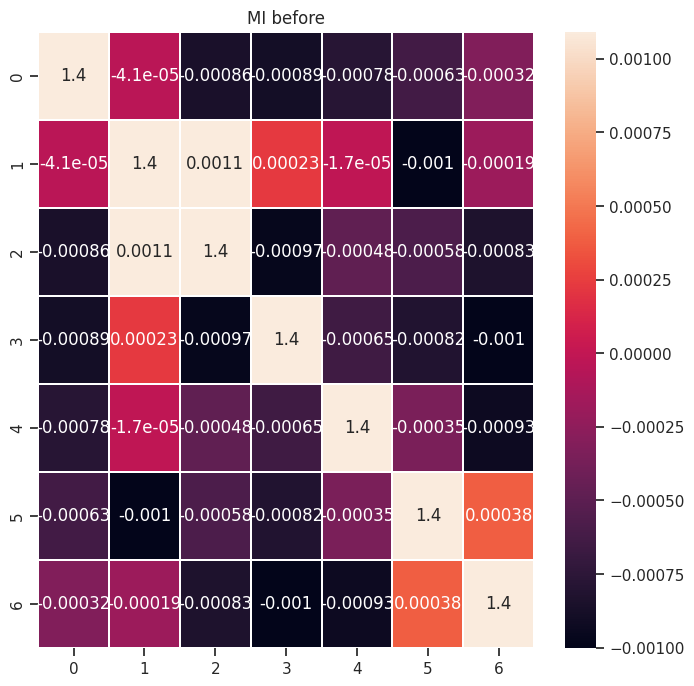

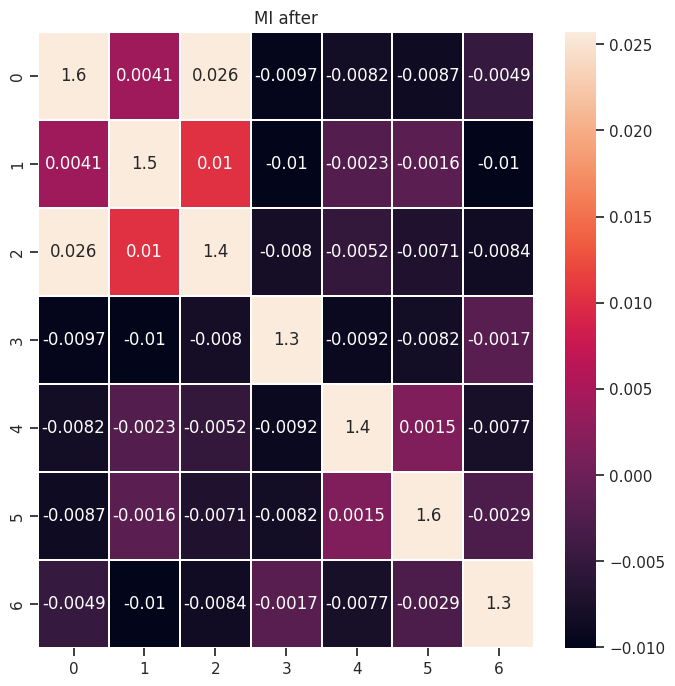


*** Covarience ***


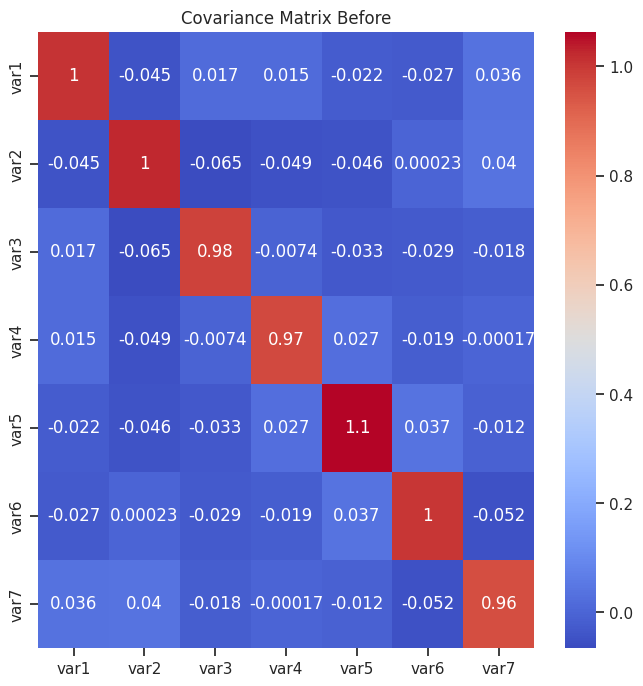

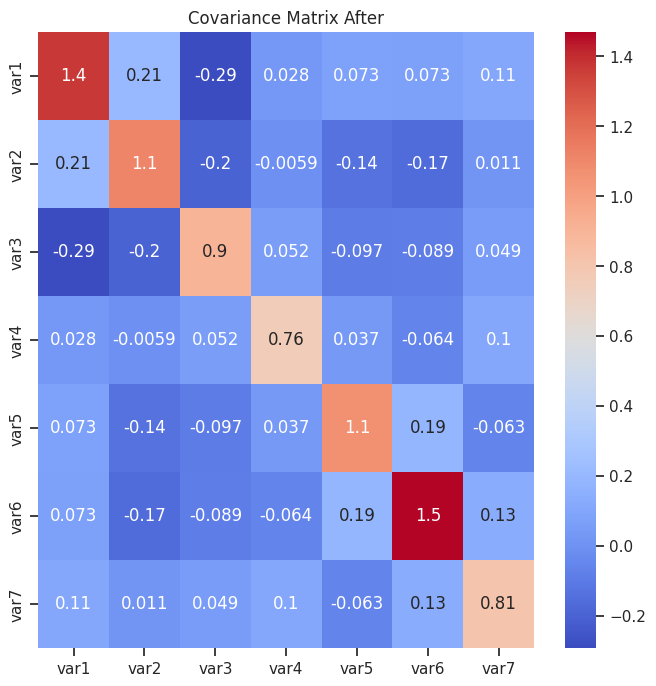


*** Pairplot ***


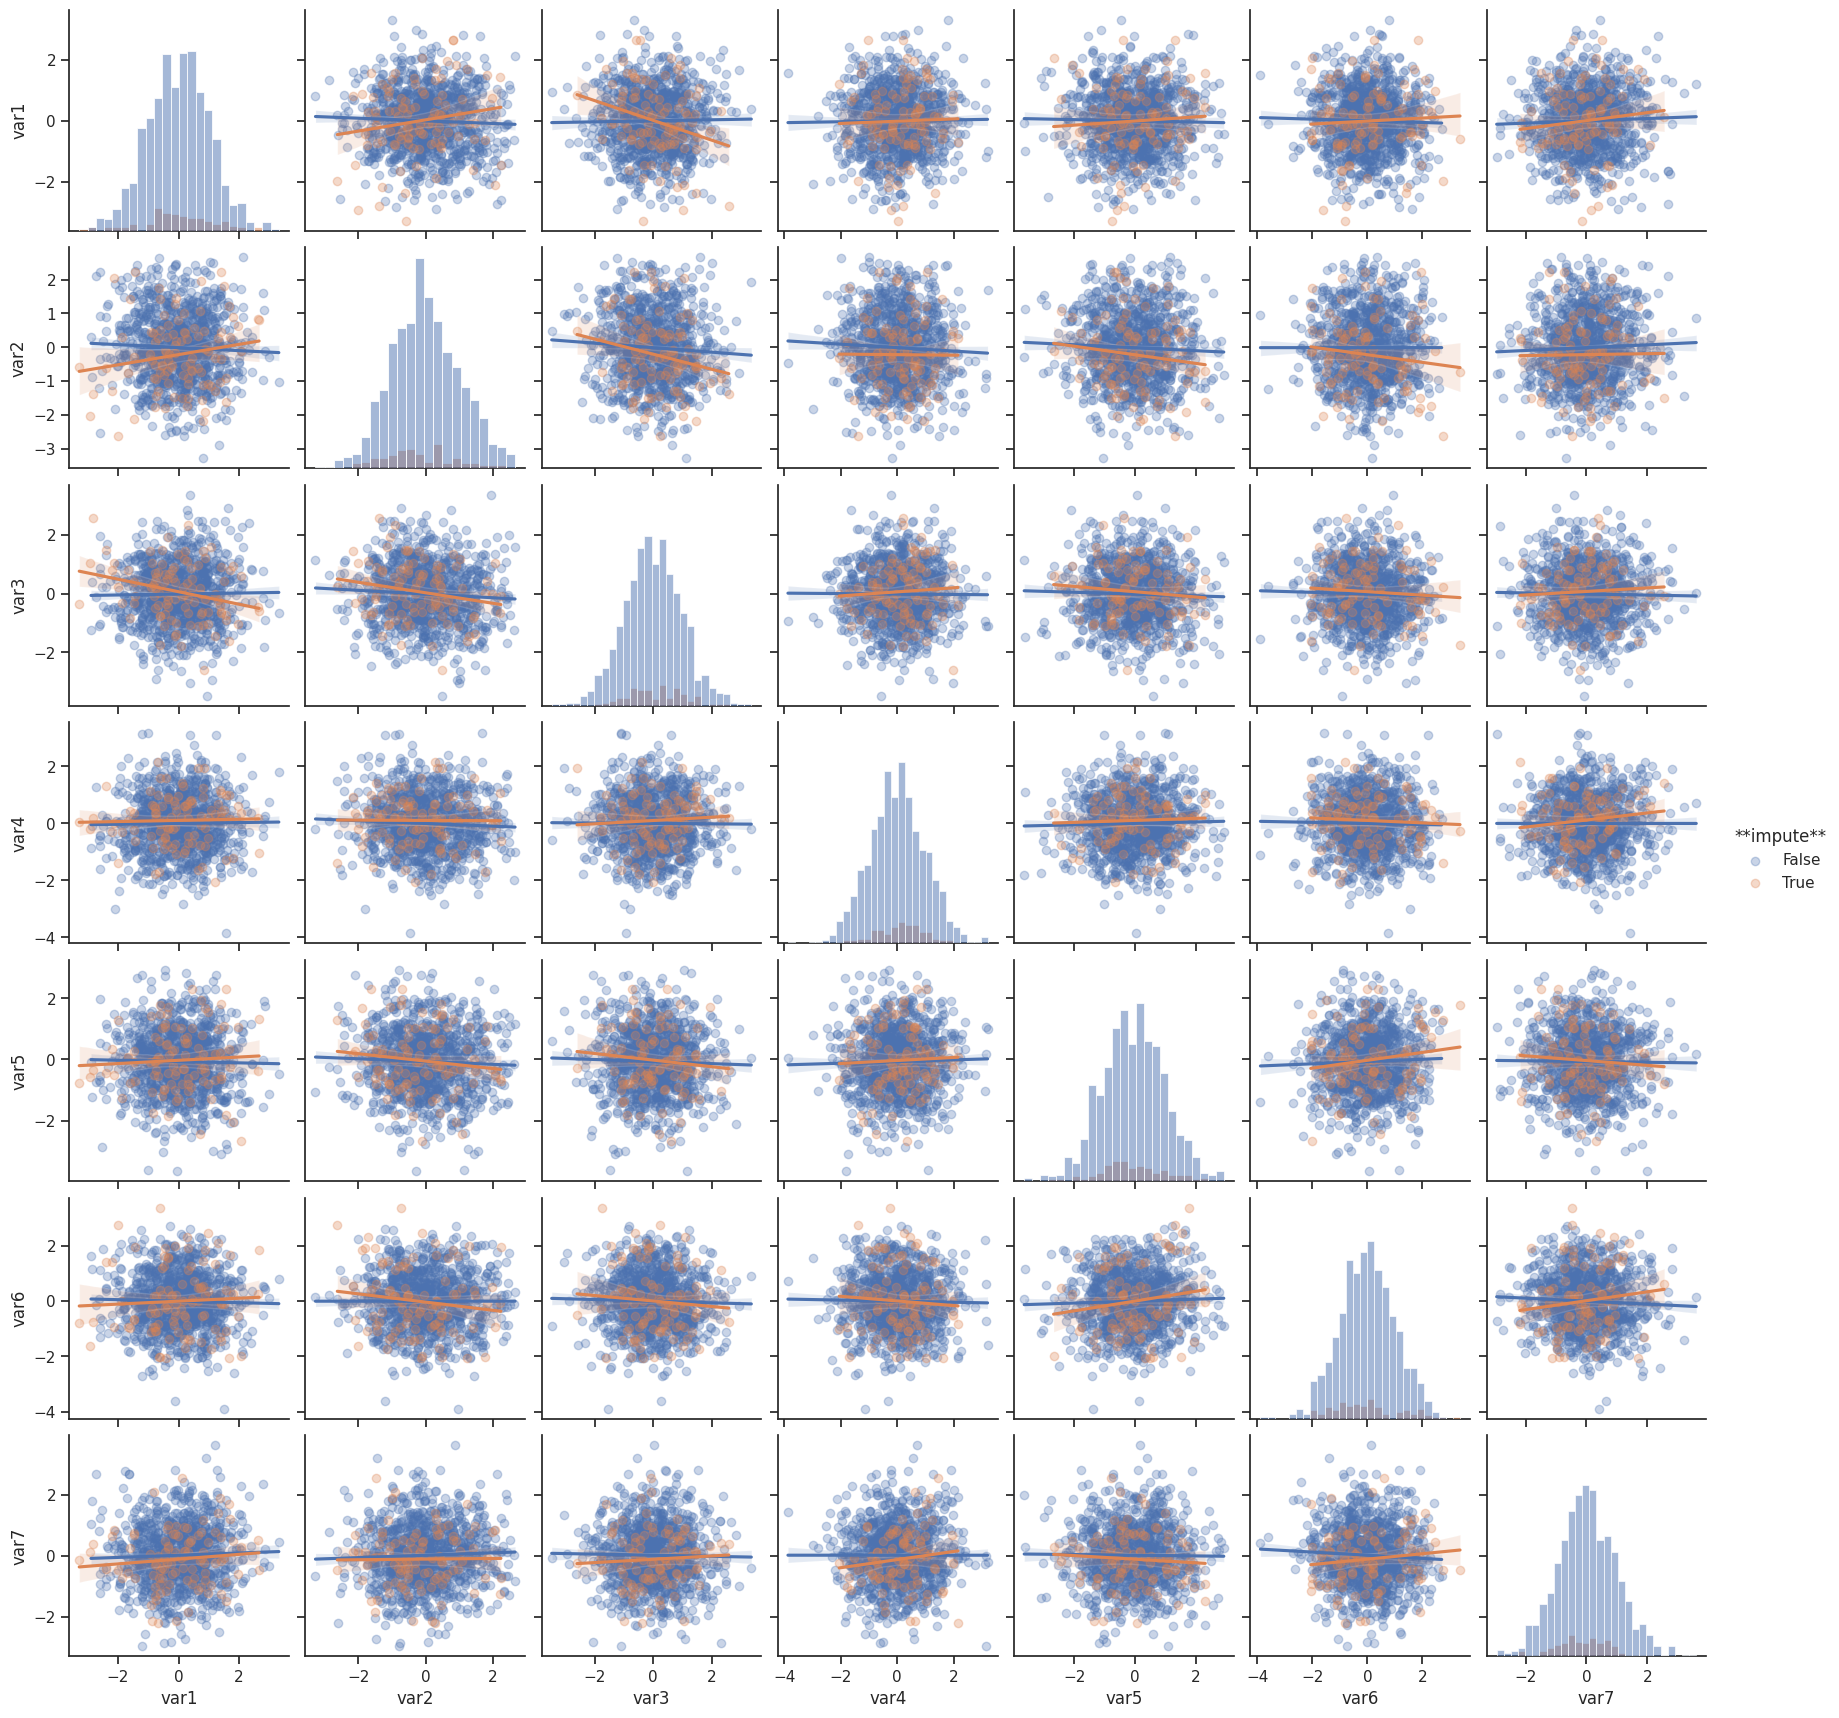

In [26]:
import pandas as pd
import numpy as np

df = pd.DataFrame(np.random.randn(1000, 7), columns=['var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7'])
tmp = pd.DataFrame(np.random.randn(100, 7), columns=['var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7'])

con = continuous()
my_frame = con.comparison(df, tmp)